# Initial Investigations: Neural Networks with Uncertainty
This notebook explores building neural networks that provide uncertainty measures and evaluates metrics that leverage those uncertainty measures to assess the model’s accuracy and robustness.

Uncertainty measures collected in this notebook include:
* *complement of the confidence score*: measures the complement of the model"s maximum softmax probability, used as a proxy for certainty.
* *predictive entropy*: measures the overall uncertainty in the predicted class distribution.
* *predictive standard deviation*: captures variability in predictions over multiple stochastic predictions.

Note that the first two measures require a single prediction for each test input, while the third one requires multiple predictions for the same test input, e.g., coming from **Monte Carlo Dropout** or **Ensemble**.

These measures are used to define the following uncertainty based metrics:
* *Area Under Uncertainty Receiver Operating Characteristic (AU-UROC)*: measures how well uncertainty separates correct and incorrect predictions. The ROC curve is constructed by varying a threshold on the uncertainty scores:
    - Unknown on wrong rate: fraction of incorrect predictions flagged as unknown (i.e., uncertainty above the threshold).
    - Unknown on correct rate: fraction of correct predictions flagged as unknown.
* *Accuracy With Threshold*: computes the accuracy only with the predictions for which the uncertainty is under a user defined threshold.
* *Uncertainty Weighted Accuracy*: computes a weighted accuracy where correct predictions are down-weighted and incorrect ones are up-weighted based on uncertainty.

Note that the first metric (AU-UROC) is solely used to evaluate how uncertainty correlates with prediction errors. *Traditional* accuracy is also included as a baseline.

The proposed metrics are then used to compute the model"s robustness under distributional shifts or data corruption.

## Importing all the libraries
This section imports all required libraries for building and evaluating neural networks, handling data, and computing uncertainty measures and metrics. The core libraries include TensorFlow/Keras for modeling and NumPy for numerical operations.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout
from keras.datasets.mnist import load_data
from keras.utils import to_categorical
from keras.models import clone_model
from tabulate import tabulate


## Loading the dataset
The MNIST handwritten digit dataset is loaded and preprocessed. Input images are flattened and normalized to the range \([0, 1]\), and target labels are one-hot encoded to be compatible with categorical cross-entropy loss.

In [64]:
(x_train, y_train), (x_test, y_test) = load_data()
# Normalize the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Flatten the data (from 28x28 to 784)
original_shape = x_train.shape[1:]
flattened_input_shape = np.prod(x_train.shape[1:])
x_train = x_train.reshape((x_train.shape[0], flattened_input_shape))
x_test = x_test.reshape((x_test.shape[0], flattened_input_shape))
# Convert labels to one-hot encoding (needed for categorical crossentropy)
n_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
# Print dataset info
print(f"Training samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")
print(f"Original image shape: {original_shape[0]}x{original_shape[1]}")
print(f"Flattened input shape: {flattened_input_shape}")
print(f"Number of classes: {n_classes}")

Training samples: 60000, Test samples: 10000
Original image shape: 28x28
Flattened input shape: 784
Number of classes: 10


## Simple baseline model definition, compilation, and training
This section defines, compiles, and trains a baseline neural network model on the MNIST dataset. The model is a simple multilayer perceptron (MLP) with Dropout, and it serves as a starting point for later comparisons with more advanced architectures (e.g., ResNet).

### Building the model

In [65]:
model = keras.Sequential([
    Dense(units=16, input_shape=(flattened_input_shape,), activation="relu"), # hidden layer
    Dropout(0.5), # dropout
    Dense(units=16, activation="relu"), # hidden layer
    Dense(units=n_classes, activation="softmax"), # output layer
])

### Compiling the model

In [66]:
# Define compile config (used later for ensemble)
compile_config = {
    "optimizer" : "adam",
    "loss" : "categorical_crossentropy",
    "metrics" : ["accuracy"]
}
# Compile the model
model.compile(**compile_config)

### Training the model
The model is trained for a fixed number of epochs with an 80/20 training-validation split.

In [67]:
# Define training config (used later for ensemble)
train_config = {
    "epochs": 10,
    "batch_size": 64,
    "validation_split": 0.2,
    "shuffle": True,
    "verbose": 2
}
# Train the model
history = model.fit(x_train, y_train, **train_config)

Epoch 1/10
750/750 - 1s - loss: 1.3112 - accuracy: 0.5361 - val_loss: 0.4965 - val_accuracy: 0.8913
Epoch 2/10
750/750 - 0s - loss: 0.9282 - accuracy: 0.6662 - val_loss: 0.3810 - val_accuracy: 0.9078
Epoch 3/10
750/750 - 0s - loss: 0.8846 - accuracy: 0.6838 - val_loss: 0.3549 - val_accuracy: 0.9116
Epoch 4/10
750/750 - 0s - loss: 0.8523 - accuracy: 0.6977 - val_loss: 0.3480 - val_accuracy: 0.9101
Epoch 5/10
750/750 - 0s - loss: 0.8342 - accuracy: 0.7060 - val_loss: 0.3401 - val_accuracy: 0.9119
Epoch 6/10
750/750 - 0s - loss: 0.8189 - accuracy: 0.7120 - val_loss: 0.3405 - val_accuracy: 0.9147
Epoch 7/10
750/750 - 0s - loss: 0.8028 - accuracy: 0.7192 - val_loss: 0.3312 - val_accuracy: 0.9155
Epoch 8/10
750/750 - 0s - loss: 0.7910 - accuracy: 0.7275 - val_loss: 0.3229 - val_accuracy: 0.9186
Epoch 9/10
750/750 - 0s - loss: 0.7695 - accuracy: 0.7368 - val_loss: 0.3220 - val_accuracy: 0.9211
Epoch 10/10
750/750 - 0s - loss: 0.7595 - accuracy: 0.7413 - val_loss: 0.3208 - val_accuracy: 0.9187

### Visualizing training progress

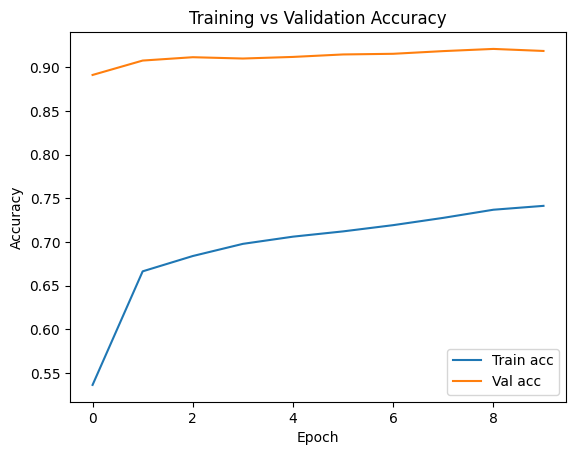

In [68]:
# Plot trainininng vs validation accuracy
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

## Defining uncertainty measures
Each method computes uncertainty in a different way. The first two (i.e., complement of the max probability and entropy) operate on a single probability vector produced by a single prediction. The third one (i.e., standard deviation of max probabilities) require multiple prediction vectors, such as those generated from ensemble models or Monte Carlo Dropout.

In [69]:
def compute_confidence_complement(prediction):
    """
    Compute the complement of the model's confidence score (i.e., the maximum predicted probability).
    Parameters:
        prediction (np.ndarray): 1D array of class probabilities from a single prediction.
    Returns:
        float: 1 - max(probability), representing uncertainty. Higher values indicate lower confidence.
    """
    return 1 - max(prediction)

In [70]:
def compute_entropy(prediction, epsilon=1e-12):
    """
    Compute the normalized Shannon entropy of the class probability distribution.
    Parameters:
        prediction (np.ndarray): 1D array of class probabilities from a single prediction.
        epsilon (float): Small value added for numerical stability to avoid log(0). Default is 1e-12.
    Returns:
        float: Normalized entropy in [0, 1], representing uncertainty. Higher values indicate lower confidence.
    """
    prediction = np.clip(prediction, epsilon, 1.0)  # avoid log(0)
    entropy = -np.sum(prediction * np.log(prediction))/np.log(len(prediction))
    return entropy

In [71]:
def compute_std_of_max_probs(predictions):
    """
    Compute the standard deviation of the maximum class probabilities across multiple stochastic predictions for the same input.
    Parameters:
        predictions (np.ndarray): 2D array (num_runs x num_classes), each row is a probability vector from one prediction.
    Returns:
        float: Standard deviation of the max probabilities, representing uncertainty. Higher values indicate lower confidence.
    """
    max_probs = np.max(predictions, axis=1)
    standard_deviation = np.std(max_probs, axis=0)
    return standard_deviation

## Defining uncertainty-based metrics
After defining basic uncertainty measures (such as predictive entropy and standard deviation of softmax scores), we now introduce higher-level metrics that leverage uncertainty measures to assess model behavior.
The following uncertainty-based metrics are defined:
* *Area Under Uncertainty Receiver Operating Characteristic (AU-UROC)*
* *Accuracy With Threshold*
* *Uncertainty Weighted Accuracy*


In [72]:
def compute_accuracies(predictions, uncertainties, true_labels, threshold):
    """
    Compute three accuracy metrics:
    - Traditional accuracy (acc_traditional)
    - Accuracy with threshold (acc_thresholded): only for predictions with uncertainty < threshold
    - Uncertainty-weighted accuracy (acc_weighted): downweights correct predictions by uncertainty, upweights incorrect ones
    Parameters:
        predictions (np.ndarray): Predicted class probabilities (n_samples x n_classes)
        uncertainties (np.ndarray): Uncertainty scores for each prediction (n_samples,)
        true_labels (np.ndarray): One-hot encoded true labels (n_samples x n_classes)
        threshold (float): Uncertainty threshold used for filtering in acc_thresholded
    Returns:
        tuple: (acc_traditional, acc_thresholded, acc_weighted)
    """
    correct_predictions = np.array([
        1 if np.argmax(pred) == np.argmax(true) else 0 
        for pred, true in zip(predictions, true_labels)
    ])
    thresholded_correct = 0
    thresholded_total = 0
    weighted_sum = 0
    for i in range(len(correct_predictions)):
        correct = correct_predictions[i]
        uncertainty = uncertainties[i]
        # Uncertainty-weighted accuracy: downweight correct predictions, upweight incorrect ones
        weighted_sum += correct * (1 - uncertainty) + (1 - correct) * uncertainty
        # Accuracy with threshold: only count predictions under uncertainty threshold
        if uncertainty < threshold:
            thresholded_correct += correct
            thresholded_total += 1
    acc_traditional = np.mean(correct_predictions)
    acc_weighted = weighted_sum / len(correct_predictions)
    acc_thresholded = thresholded_correct / thresholded_total if thresholded_total > 0 else None
    return acc_traditional, acc_thresholded, acc_weighted


In [73]:
def print_accuracies(acc_traditional, acc_thresholded, acc_weighted):
    """
    Print the three accuracy metrics.
    Parameters:
        acc_traditional (float): Traditional accuracy.
        acc_thresholded (float or None): Accuracy with uncertainty < threshold. May be None if no predictions qualify.
        acc_weighted (float): Uncertainty-weighted accuracy.
    """
    print(f"Traditional accuracy:\t\t{acc_traditional*100:.2f}%")
    if acc_thresholded is not None: 
        print(f"Thresholded accuracy:\t\t{acc_thresholded*100:.2f}%")
    else:
        print(f"Thresholded accuracy:\t\tundefined")
    print(f"Uncertainty weighted accuracy:\t{acc_weighted*100:.2f}%")

In [74]:
def compute_uroc(predictions, uncertainties, true_labels, n_thresholds):
    """
    Compute an approximation of the Uncertainty ROC curve.
    Parameters:
        predictions (np.ndarray): Predicted class probabilities (n_samples x n_classes)
        uncertainties (np.ndarray): Uncertainty values for each prediction (n_samples,)
        true_labels (np.ndarray): One-hot encoded true labels (n_samples x n_classes)
        n_thresholds (int): Number of uncertainty thresholds to evaluate
    Returns:
        List[Tuple[float, float]]: List of (x, y) points where:
            x = fraction of correct predictions flagged as unknown
            y = fraction of incorrect predictions flagged as unknown
    """
    correct_predictions = np.array([
        1 if np.argmax(pred) == np.argmax(true) else 0 
        for pred, true in zip(predictions, true_labels)
    ])
    thresholds = [i / n_thresholds for i in range(n_thresholds, -1, -1)]
    points = []
    for threshold in thresholds:
        unknown_mask = np.array([1 if u > threshold else 0 for u in uncertainties])
        correct_total = np.sum(correct_predictions)
        incorrect_total = len(correct_predictions) - correct_total
        unknown_on_correct = np.sum(unknown_mask * correct_predictions) if correct_total > 0 else 0
        unknown_on_incorrect = np.sum(unknown_mask * (1 - correct_predictions)) if incorrect_total > 0 else 0
        x = unknown_on_correct / correct_total if correct_total > 0 else 0
        y = unknown_on_incorrect / incorrect_total if incorrect_total > 0 else 0
        points.append((x, y))
    return points

In [75]:
def compute_au_uroc(points):
    """
    Compute the area under the Uncertainty ROC curve using the trapezoidal rule.
    Parameters:
        points (List[Tuple[float, float]]): ROC points as (x, y) coordinates
    Returns:
        float: Area under the ROC curve (AU-UROC)
    """
    x, y = zip(*points)
    return np.trapz(np.array(y), np.array(x))

In [76]:
def plot_uroc(points, area=None):
    """
    Plot the Uncertainty ROC curve.
    Parameters:
        points (List[Tuple[float, float]]): ROC points as (x, y) coordinates
        area (float, optional): Area under the curve to display in the title
    """
    x, y = zip(*points)
    plt.figure(figsize=(4, 4))
    plt.plot(x, y, marker="o", linestyle="-", linewidth=2)
    plt.fill_between(x, y, alpha=0.2)
    plt.xlabel("Unknown on correct rate")
    plt.ylabel("Unknown on incorrect rate")
    title = "Uncertainty ROC Curve"
    if area is not None:
        title += f" (AU-UROC = {area * 100:.2f}%)"
    plt.title(title)
    plt.grid(False)
    plt.show()

## Training ensemble models
To estimate uncertainty using ensemble methods, multiple neural networks with the same architecture but different random initializations are trained. Each model is trained independently on the same dataset.

In [77]:
def train_ensemble_models(base_model, x_train, y_train, compile_config, train_config, n_models):
    """
    Train an ensemble of models independently using the same architecture and training configuration.
    Parameters:
        base_model (keras.Model): An untrained base model to replicate.
        x_train (ndarray): Training input data.
        y_train (ndarray): Training labels.
        compile_config (dict): Dictionary of compile arguments (e.g., optimizer, loss, metrics).
        train_config (dict): Dictionary of training arguments (e.g., epochs, batch_size).
        n_models (int): Number of models to train in the ensemble.
    Returns:
        List[keras.Model]: A list of trained Keras models, each trained independently.
    """
    models = []
    for i in range(n_models):
        print(f"-- Training model {i + 1}/{n_models} --")
        model = clone_model(base_model)
        model.compile(**compile_config)
        model.fit(x_train, y_train, **train_config)
        models.append(model)
    return models

In [78]:
ensamble_models = train_ensemble_models(model, x_train, y_train, compile_config, train_config, n_models=5)

-- Training model 1/5 --
Epoch 1/10
750/750 - 0s - loss: 1.2471 - accuracy: 0.5506 - val_loss: 0.4967 - val_accuracy: 0.8820
Epoch 2/10
750/750 - 0s - loss: 0.8794 - accuracy: 0.6754 - val_loss: 0.4049 - val_accuracy: 0.8931
Epoch 3/10
750/750 - 0s - loss: 0.8222 - accuracy: 0.7000 - val_loss: 0.3610 - val_accuracy: 0.9021
Epoch 4/10
750/750 - 0s - loss: 0.7888 - accuracy: 0.7162 - val_loss: 0.3528 - val_accuracy: 0.9040
Epoch 5/10
750/750 - 0s - loss: 0.7709 - accuracy: 0.7241 - val_loss: 0.3454 - val_accuracy: 0.9057
Epoch 6/10
750/750 - 0s - loss: 0.7591 - accuracy: 0.7283 - val_loss: 0.3430 - val_accuracy: 0.9084
Epoch 7/10
750/750 - 0s - loss: 0.7440 - accuracy: 0.7375 - val_loss: 0.3207 - val_accuracy: 0.9103
Epoch 8/10
750/750 - 0s - loss: 0.7333 - accuracy: 0.7435 - val_loss: 0.3240 - val_accuracy: 0.9113
Epoch 9/10
750/750 - 0s - loss: 0.7199 - accuracy: 0.7487 - val_loss: 0.3190 - val_accuracy: 0.9102
Epoch 10/10
750/750 - 0s - loss: 0.7129 - accuracy: 0.7530 - val_loss: 0.33

## Applying uncertainty measures and uncertainty based metrics
In this section, we apply the previously defined uncertainty measures and metrics to analyze the behavior of the trained model on the MNIST dataset.

### Uncertainty measures

In [79]:
# Get softmax predictions from a single deterministic prediction (used for entropy and max complement)
predictions = model.predict(x_test)
print(f"Single-pass predictions shape: {predictions.shape}")

Single-pass predictions shape: (10000, 10)


In [80]:
# Generate multiple stochastic predictions using Monte Carlo Dropout
n_mc_passes  = 5
mc_predictions = np.array([model(x_test, training=True) for _ in range(n_mc_passes)])
print(f"MC Dropout predictions shape: {mc_predictions.shape}")  # Expect (n_mc_passes, n_samples, n_classes)

MC Dropout predictions shape: (5, 10000, 10)


In [81]:
# Generate predictions from each model in the ensemble
ensemble_predictions = np.array([model(x_test, training=False) for model in ensamble_models])
print(f"Ensemble predictions shape: {ensemble_predictions.shape}")  # Expect (n_models, n_samples, n_classes)

Ensemble predictions shape: (5, 10000, 10)


In [82]:
# Extract predicted and true class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
# Compute uncertainty scores for single-pass predictions
uncertainty_confidence_complement = np.array([compute_confidence_complement(p) for p in predictions])
uncertainty_entropy = np.array([compute_entropy(p) for p in predictions])
# Compute MC Dropout-based uncertainty (std of max probs over multiple runs)
mean_mc_predictions = np.mean(mc_predictions, axis=0)
mc_predicted_labels = np.argmax(mean_mc_predictions, axis=1)
mc_predictions_stacked = np.moveaxis(mc_predictions, 1, 0) # Group predictions by sample
uncertainty_mc_dropout = np.array([compute_std_of_max_probs(p) for p in mc_predictions_stacked])
uncertainty_mc_dropout_entropy = np.array([compute_entropy(p) for p in mean_mc_predictions])
# Compute Ensemble-based uncertainty (std of max probs over ensemble members)
mean_ensemble_predictions = np.mean(ensemble_predictions, axis=0)
ensemble_predicted_labels = np.argmax(mean_ensemble_predictions, axis=1)
ensemble_predictions_stacked = np.moveaxis(ensemble_predictions, 1, 0) # Group predictions by sample
uncertainty_ensemble = np.array([compute_std_of_max_probs(p) for p in ensemble_predictions_stacked])
uncertainty_ensemble_entropy = np.array([compute_entropy(p) for p in mean_ensemble_predictions])
# Print quick summary of average uncertainties
print("\nMean uncertainty scores:")
print(f"  Confidence Complement:      {np.mean(uncertainty_confidence_complement)*100:.2f}%")
print(f"  Entropy:                    {np.mean(uncertainty_entropy)*100:.2f}%")
print(f"  MC Dropout - max probs std: {np.mean(uncertainty_mc_dropout)*100:.2f}%")
print(f"  MC Dropout - mean entropy:  {np.mean(uncertainty_mc_dropout_entropy)*100:.2f}%")
print(f"  Ensemble - max probs std:   {np.mean(uncertainty_ensemble)*100:.2f}%")
print(f"  Ensemble - mean entropy:    {np.mean(uncertainty_ensemble_entropy)*100:.2f}%")


Mean uncertainty scores:
  Confidence Complement:      16.31%
  Entropy:                    22.49%
  MC Dropout - max probs std: 17.64%
  MC Dropout - mean entropy:  46.44%
  Ensemble - max probs std:   7.25%
  Ensemble - mean entropy:    23.16%


In [83]:
# Summarize uncertainty statistics
uncertainty_labels = ["Conf. Complement", "Entropy", "MC Dropout\nmax probs std", "MC Dropout\nmean entropy", "Ensemble\nmax probs std", "Ensemble\nmean entropy"]
uncertainty_measures = [
    uncertainty_confidence_complement,
    uncertainty_entropy,
    uncertainty_mc_dropout,
    uncertainty_mc_dropout_entropy,
    uncertainty_ensemble,
    uncertainty_ensemble_entropy
]
summary_data = [
    ["Uncertainty [%]"] + uncertainty_labels,
    ["Min"]  + [100*np.min(u) for u in uncertainty_measures],
    ["Max"]  + [100*np.max(u) for u in uncertainty_measures],
    ["Mean"] + [100*np.mean(u) for u in uncertainty_measures],
    ["Std"]  + [100*np.std(u) for u in uncertainty_measures],
]
print("Uncertainty Summary Statistics")
colalign = ("right",) + ("center",) * (len(summary_data[0]) - 1)
print(tabulate(summary_data, headers="firstrow", floatfmt=".2f", tablefmt="grid", colalign=colalign))

Uncertainty Summary Statistics
+-------------------+--------------------+-----------+-----------------+----------------+-----------------+----------------+
|   Uncertainty [%] |  Conf. Complement  |  Entropy  |   MC Dropout    |   MC Dropout   |    Ensemble     |    Ensemble    |
|                   |                    |           |  max probs std  |  mean entropy  |  max probs std  |  mean entropy  |
+===================+====================+===========+=================+================+=================+================+
|               Min |        0.00        |   0.01    |      0.00       |      0.03      |      0.00       |      0.01      |
+-------------------+--------------------+-----------+-----------------+----------------+-----------------+----------------+
|               Max |       81.81        |   94.65   |      36.47      |     96.56      |      26.55      |     96.33      |
+-------------------+--------------------+-----------+-----------------+----------------+-----

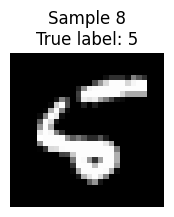

Uncertainty measures for sample 8:
  * Single prediction - predicted 6:
     - Max Complement = 41.78%
     - Entropy = 54.35%
  * MC Dropout - predicted 6:
     - Max probs std = 24.24%
     - Mean entropy = 54.15%
  * Ensemble - predicted 4:
     - Max probs std = 9.34%
     - Mean entropy = 47.36%


In [84]:
# Visualize the sample image with index 8 (found to be difficult to calssify)
sample_index = 8
plt.figure(figsize=(2, 2))  # Shrink the image display size
plt.imshow(x_test[sample_index].reshape(28, 28), cmap="gray")
plt.title(f"Sample {sample_index}\nTrue label: {true_labels[sample_index]}")
plt.axis("off")
plt.show()
# Print uncertainty measures and predictions
print(f"Uncertainty measures for sample {sample_index}:")
print(f"  * Single prediction - predicted {predicted_labels[sample_index]}:")
print(f"     - Max Complement = {uncertainty_confidence_complement[sample_index]*100:.2f}%")
print(f"     - Entropy = {uncertainty_entropy[sample_index]*100:.2f}%")
print(f"  * MC Dropout - predicted {mc_predicted_labels[sample_index]}:")
print(f"     - Max probs std = {uncertainty_mc_dropout[sample_index]*100:.2f}%")
print(f"     - Mean entropy = {uncertainty_mc_dropout_entropy[sample_index]*100:.2f}%")
print(f"  * Ensemble - predicted {ensemble_predicted_labels[sample_index]}:")
print(f"     - Max probs std = {uncertainty_ensemble[sample_index]*100:.2f}%")
print(f"     - Mean entropy = {uncertainty_ensemble_entropy[sample_index]*100:.2f}%")

### Uncertainty based metrics

In [85]:
def evaluate_uncertainty_metrics(name, predictions, uncertainties, true_labels, threshold, n_roc_points):
    """
    Evaluate a model"s performance using uncertainty measures.
    This function prints:
    - Traditional accuracy
    - Accuracy with threshold (only predictions below uncertainty threshold are considered)
    - Uncertainty-weighted accuracy (downweights correct predictions by uncertainty, upweights incorrect ones)
    - Area under the Uncertainty ROC curve (AU-UROC)
    It also displays the UROC curve plot.
    Parameters:
        name (str): Name of the uncertainty method (for labeling output and plots)
        predictions (np.ndarray): Predicted class probabilities (n_samples x n_classes)
        uncertainties (np.ndarray): Uncertainty scores associated with each prediction (n_samples,)
        true_labels (np.ndarray): One-hot encoded ground truth labels (n_samples x n_classes)
        threshold (float): Uncertainty threshold for filtering predictions in accuracy-with-threshold
        n_roc_points (int): Number of thresholds to use for UROC curve approximation
    Returns:
        None
    """
    print(f"\n=== {name} ===")
    acc_trad, acc_thresh, acc_weighted = compute_accuracies(predictions, uncertainties, true_labels, threshold)
    print_accuracies(acc_trad, acc_thresh, acc_weighted)
    roc_curve = compute_uroc(predictions, uncertainties, true_labels, n_roc_points)
    au_uroc = compute_au_uroc(roc_curve)
    plot_uroc(roc_curve, area=au_uroc)

In [86]:
# Set parameters for evaluation
threshold = 0.2 # output is flagged as unknown if uncertainty > 20%
roc_n_points = 20 


=== Confidence Complement ===
Traditional accuracy:		91.24%
Thresholded accuracy:		98.77%
Uncertainty weighted accuracy:	83.06%


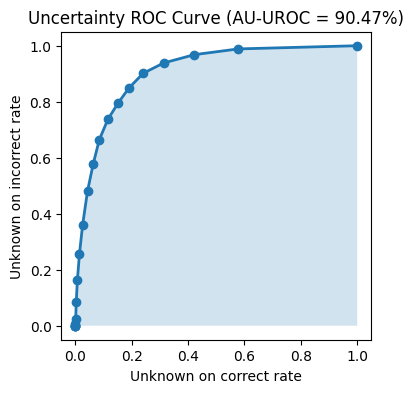

In [87]:
evaluate_uncertainty_metrics(
    name="Confidence Complement",
    predictions=predictions,
    uncertainties=uncertainty_confidence_complement,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)


=== Entropy ===
Traditional accuracy:		91.24%
Thresholded accuracy:		99.34%
Uncertainty weighted accuracy:	78.04%


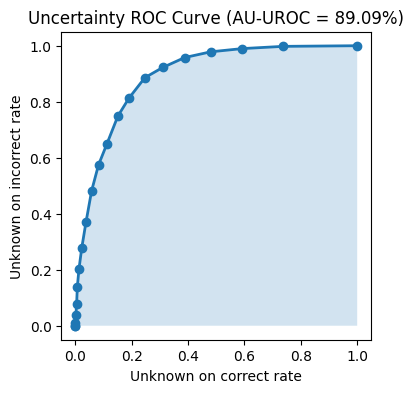

In [88]:
evaluate_uncertainty_metrics(
    name="Entropy",
    predictions=predictions,
    uncertainties=uncertainty_entropy,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)


=== MC Dropout - max probs std ===
Traditional accuracy:		89.43%
Thresholded accuracy:		85.47%
Uncertainty weighted accuracy:	74.92%


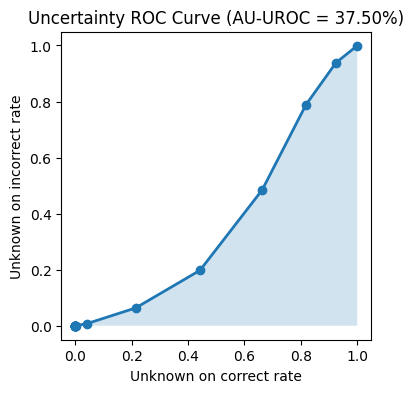

In [89]:
evaluate_uncertainty_metrics(
    name="MC Dropout - max probs std",
    predictions=mean_mc_predictions,
    uncertainties=uncertainty_mc_dropout,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)


=== MC Dropout - mean entropy ===
Traditional accuracy:		89.43%
Thresholded accuracy:		99.49%
Uncertainty weighted accuracy:	57.32%


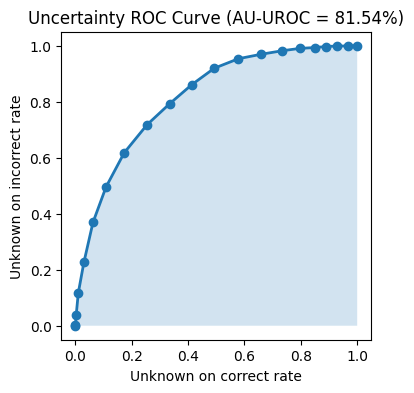

In [90]:
evaluate_uncertainty_metrics(
    name="MC Dropout - mean entropy",
    predictions=mean_mc_predictions,
    uncertainties=uncertainty_mc_dropout_entropy,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)


=== Ensemble - max probs std ===
Traditional accuracy:		92.52%
Thresholded accuracy:		92.67%
Uncertainty weighted accuracy:	86.99%


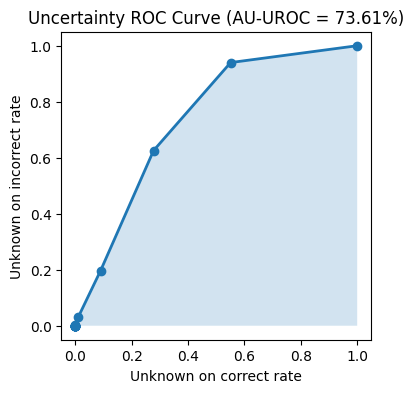

In [91]:
evaluate_uncertainty_metrics(
    name="Ensemble - max probs std",
    predictions=mean_ensemble_predictions,
    uncertainties=uncertainty_ensemble,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)


=== Ensemble - mean entropy ===
Traditional accuracy:		92.52%
Thresholded accuracy:		99.76%
Uncertainty weighted accuracy:	77.74%


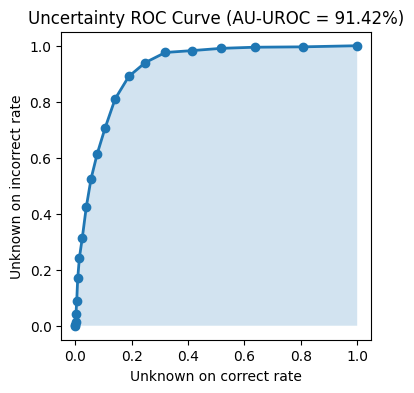

In [92]:
evaluate_uncertainty_metrics(
    name="Ensemble - mean entropy",
    predictions=mean_ensemble_predictions,
    uncertainties=uncertainty_ensemble_entropy,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)